In [1]:
from PIL import Image
import torch
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [9]:
# load the orginal and edited image 
mode=2
if mode==1:
    subject = 'patient32736'
    root_path = '/usr/local/data/amarkr/lgcig/outputs/explain_cardiomegaly_chexpert_imageedit'
    original_img = Image.open(os.path.join(root_path,subject,'view1_frontal/img.jpeg')).convert('L')
    edited_img = Image.open(os.path.join(root_path,subject,'edited/np_finding.jpeg')).convert('L')
else:
    original_img = Image.open('/usr/local/data/amarkr/lgcig/outputs/chexpert_test/patient00375/view1_frontal/img.jpeg').convert('L')
    edited_img = Image.open('/usr/local/data/amarkr/lgcig/outputs/chexpert_test/patient00375/edited/without.jpeg').convert('L')


#change the images to numpy arrays
original = np.array(original_img)
edited = np.array(edited_img)

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_max_changes(original, edited, percentile_threshold=90):
    """
    Visualize regions with maximum changes between two images with normalization
    
    Parameters:
        original: numpy array of original image
        edited: numpy array of edited image
        percentile_threshold: percentile value to identify significant changes (default: 95)
    """
    # Calculate difference
    diff_img =  original.astype(float) -edited.astype(float) 
    
    # Normalize difference to [0,1]
    diff_normalized = (diff_img - np.min(diff_img)) / (np.max(diff_img) - np.min(diff_img))
    
    # Print statistics
    print(f"Original difference range: {np.min(diff_img):.3f} to {np.max(diff_img):.3f}")
    print(f"Normalized difference range: {np.min(diff_normalized):.3f} to {np.max(diff_normalized):.3f}")
    
    # Calculate threshold based on normalized differences
    max_change_threshold = np.percentile(diff_normalized, percentile_threshold)
    print(f"\nThreshold for maximum changes (at {percentile_threshold}th percentile): {max_change_threshold:.3f}")
    
    # Create mask for maximum changes
    max_change_mask = diff_normalized >= max_change_threshold
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Full normalized difference
    vmax = max(abs(np.min(diff_img)), abs(np.max(diff_img)))
    im1 = ax1.imshow(diff_img, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
    plt.colorbar(im1, ax=ax1, label='Difference (Original - Edited)')
    ax1.set_title('All Differences\n(Red: Added, Blue: Removed)')
    ax1.axis('off')

    
    # Plot 2: Show significant changes with sign
    significant_changes = diff_img * max_change_mask
    im2 = ax2.imshow(significant_changes, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
    #save this image im2
    im2.figure.savefig('/usr/local/data/amarkr/lgcig/animations/set2/im3.png')
    
    
    plt.colorbar(im2, ax=ax2, label='Significant Changes')
    ax2.set_title(f'Significant Changes Only\n(Top {100-percentile_threshold}% magnitude)')
    ax2.axis('off')
    
    plt.tight_layout()
    
    # Print statistics about the changes
    pos_changes = np.sum(significant_changes > 0)
    neg_changes = np.sum(significant_changes < 0)
    total_pixels = diff_img.size
    
    print(f"\nPixels with significant positive changes: {pos_changes} ({(pos_changes/total_pixels)*100:.2f}%)")
    print(f"Pixels with significant negative changes: {neg_changes} ({(neg_changes/total_pixels)*100:.2f}%)")
    
    return diff_img, significant_changes

# Additional function to get detailed statistics about the changes
def analyze_change_regions(max_change_mask):
    """
    Analyze the regions of maximum change
    
    Parameters:
        max_change_mask: binary mask showing regions of maximum change
    """
    from scipy import ndimage
    
    # Label connected regions
    labeled_regions, num_regions = ndimage.label(max_change_mask)
    
    # Calculate properties of each region
    regions_props = []
    for region_id in range(1, num_regions + 1):
        region_mask = labeled_regions == region_id
        region_size = np.sum(region_mask)
        region_coords = np.where(region_mask)
        
        # Calculate region center
        center_y = np.mean(region_coords[0])
        center_x = np.mean(region_coords[1])
        
        regions_props.append({
            'id': region_id,
            'size': region_size,
            'center': (center_y, center_x)
        })
    
    # Sort regions by size
    regions_props.sort(key=lambda x: x['size'], reverse=True)
    
    print("\nAnalysis of change regions:")
    print(f"Total number of distinct changed regions: {num_regions}")
    if regions_props:
        print(f"Largest region size: {regions_props[0]['size']} pixels")
        print(f"Smallest region size: {regions_props[-1]['size']} pixels")
    
    return regions_props

Original difference range: -198.000 to 255.000
Normalized difference range: 0.000 to 1.000

Threshold for maximum changes (at 70th percentile): 0.453

Pixels with significant positive changes: 84260 (32.14%)
Pixels with significant negative changes: 0 (0.00%)

Analysis of change regions:
Total number of distinct changed regions: 2298
Largest region size: 19096 pixels
Smallest region size: 1 pixels


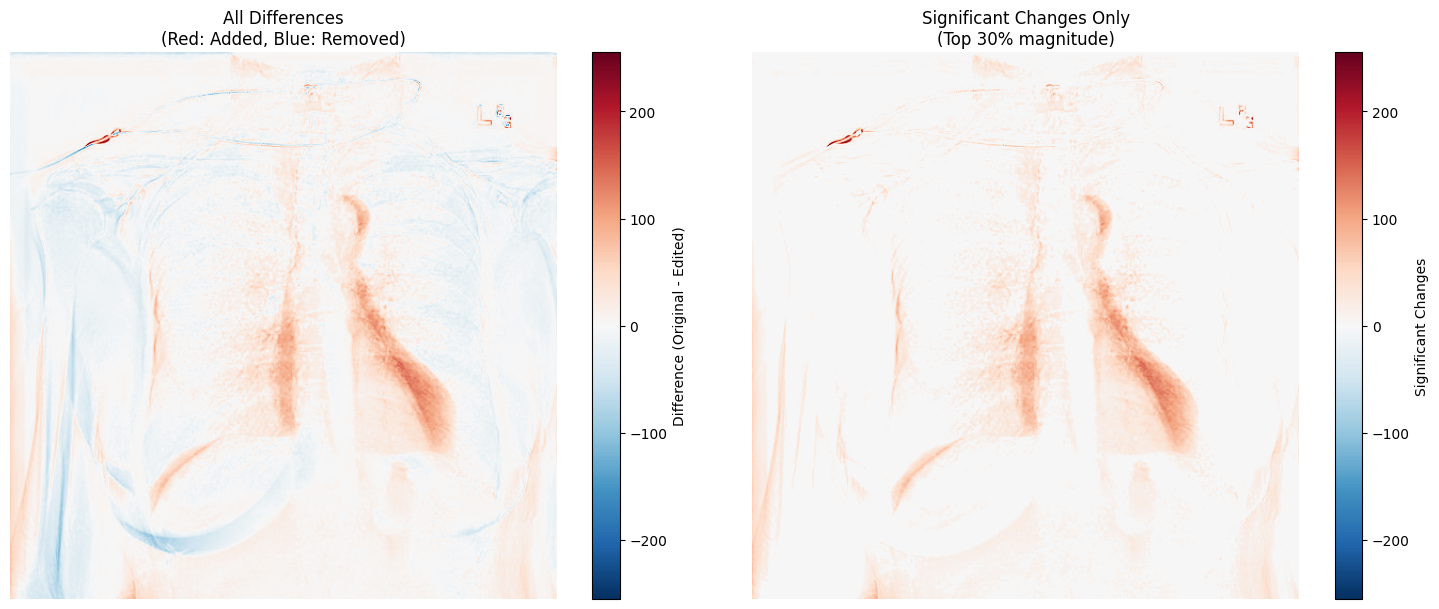

In [9]:
diff_img, max_change_mask = visualize_max_changes(original, edited, percentile_threshold=70)
regions_props = analyze_change_regions(max_change_mask)

In [12]:
diff_img =  -original.astype(float) +edited.astype(float) 

(-0.5, 511.5, 511.5, -0.5)

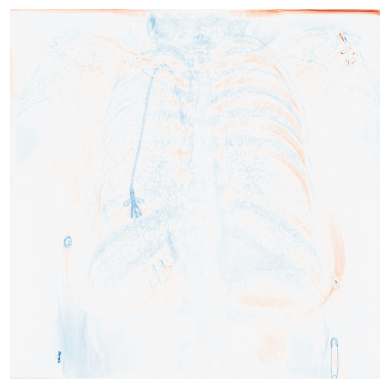

In [13]:
plt.imshow(diff_img, cmap='RdBu_r', vmin=-255, vmax=255)
plt.axis('off')